In [1]:
import hypernetx as hnx
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
from PyComplexHeatmap import *

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from incidenceToProjection import makeHiC_fromInc
#from chains import makeIncDF_fromChainDists
from utils import flatten

 No module named 'celluloid'. If you need to use hypernetx.algorithms.contagion, please install additional packages by running the following command: pip install .['all']


In [2]:
## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'

## Read in example file
exMat1 = np.loadtxt(f'{dataDir}chains_500_10000_1500_1681171613/chain_dist_5324.txt')
## Read in example file
exMat2 = np.loadtxt(f'{dataDir}chains_500_10000_1500_1681171613/chain_dist_4271.txt')

nrow = exMat1.shape[0]
cutoff = 500

In [136]:
def averageNChains(seed,sampleSize,matching_files):
    random.seed(seed)
    mat = None
    for f in random.sample(matching_files,sampleSize):
        oneChain = np.loadtxt(f)
        chainDFs.append(oneChain)
        if mat is None:
            mat = (oneChain / sampleSize)
        else:
            mat += (oneChain / sampleSize)
    return(mat)

In [127]:
distPattern = "chain_dist_*.txt"
matching_files = glob.glob(f'{dataDir}chains_500_10000_1500_1681171613/{distPattern}')
random.seed(10)
sampleSize = 4

avgMat = None
dfs = []
chainDFs = []

for f in random.sample(matching_files,sampleSize):
    oneChain = np.loadtxt(f)
    chainDFs.append(oneChain)
    if avgMat is None:
        avgMat = (oneChain / sampleSize)
    else:
        avgMat += (oneChain / sampleSize)
    chainDF = makeIncDF_fromChainDists(oneChain)
    print(chainDF.shape)
    dfs.append(chainDF)

combined_incDF = pd.concat(dfs,axis=1)
combined_incDF.shape

(500, 4327)
(500, 4295)
(500, 4251)
(500, 4009)


(500, 16882)

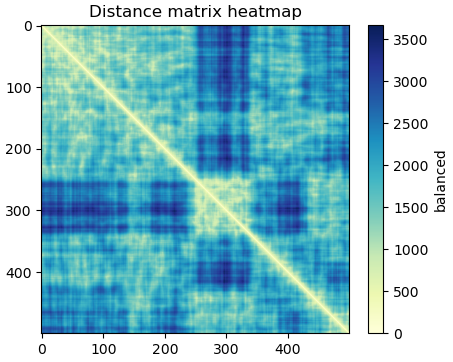

In [128]:
plt.figure(figsize=(6, 4))
im = plt.imshow(avgMat, cmap="YlGnBu")
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Distance matrix heatmap")
plt.show()

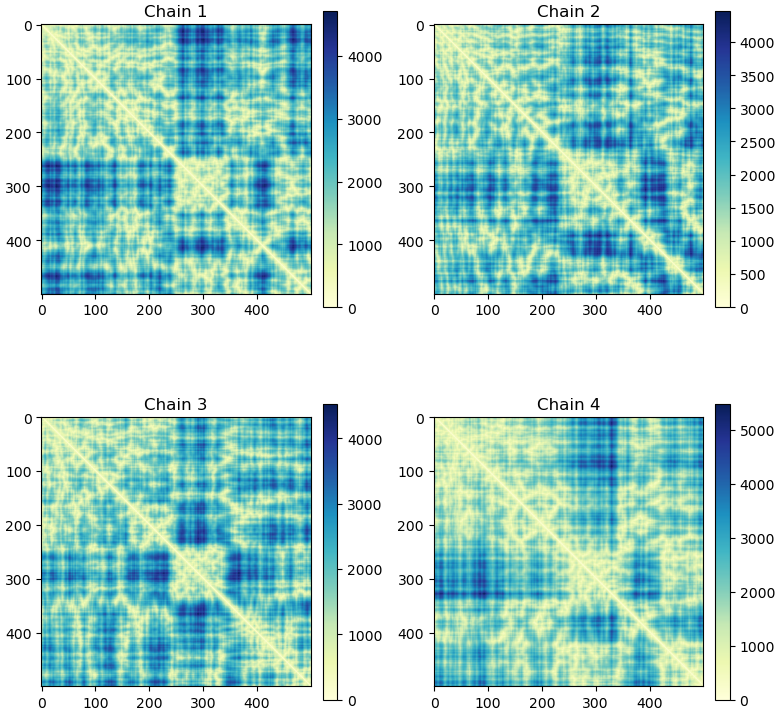

In [40]:

plt.figure(figsize=(8, 8))
 
for i, matrix in enumerate(chainDFs):
    plt.subplot(2, 2, i + 1)
    im = plt.imshow(matrix, cmap="YlGnBu")
    plt.colorbar(im, fraction=0.05, pad=0.04)
    plt.title(f"Chain {i+1}")

plt.tight_layout()
plt.show()

In [16]:
print(chainDFs[0][0:4,0:4])
print(chainDFs[1][0:4,0:4])
print(chainDFs[2][0:4,0:4])
print(chainDFs[3][0:4,0:4])
print(avgMat[0:4,0:4])


[[  0.         300.         477.01162647 569.98101192]
 [300.           0.         300.         458.46306381]
 [477.01162647 300.           0.         300.        ]
 [569.98101192 458.46306381 300.           0.        ]]
[[  0.         300.         510.28569579 524.34379442]
 [300.           0.         300.         414.19221507]
 [510.28569579 300.           0.         300.        ]
 [524.34379442 414.19221507 300.           0.        ]]
[[  0.         300.         407.21848358 396.99711687]
 [300.           0.         300.         477.52892767]
 [407.21848358 300.           0.         300.        ]
 [396.99711687 477.52892767 300.           0.        ]]
[[  0.         300.         524.44274295 584.14336124]
 [300.           0.         300.         354.56397584]
 [524.44274295 300.           0.         300.        ]
 [584.14336124 354.56397584 300.           0.        ]]
[[  0.         300.         479.7396372  518.86632111]
 [300.           0.         300.         426.1870456 ]
 [479.

In [26]:
oneChain = makeIncDF_fromChainDists(avgMat)
oneChain.shape

(500, 30)

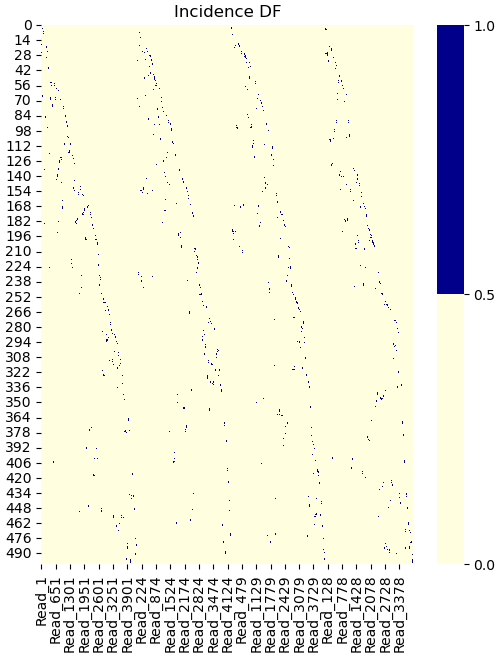

In [20]:
from matplotlib.colors import BoundaryNorm, ListedColormap

my_colors = ["lightyellow",'darkblue']
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.5, 1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

plt.figure(figsize=(6, 7))
im = sns.heatmap(combined_incDF, cmap=my_cmap,norm = my_norm)
plt.title("Incidence DF")
plt.show()

In [21]:
def makeIncDF_fromChainDists(chainMat,cutoff,offDiagLim):
    """Takes in a matrix of pairwise distances between 
    biophysically constructed chains. Outputs an incidence 
    data frame. This can be used for hypergraph construction
    or to make a hic-esque projection matrix"""
    nrow = chainMat.shape[0]
    index_range = range(nrow)
    df = pd.DataFrame(index=index_range)
    columns_to_add = []
    chainMat_triu = np.triu(chainMat, k=1)
    counter = 0
    for i in range(nrow):
        condition1 = (0 < chainMat_triu[i, i+offDiagLim:])
        condition2 = (chainMat_triu[i, i+offDiagLim:] < cutoff)
        possNeighbors = list(np.where(condition1 & condition2)[0])
        if(possNeighbors):
            for ix in range(2,len(possNeighbors)):
                for comb in combinations(possNeighbors,ix):
                    d = chainMat_triu[np.ix_(comb,comb)]
                    if d.max() <= cutoff:
                        counter += 1
                        new_column = np.zeros(nrow)
                        new_column[list(comb)] = 1
                        columns_to_add.append(pd.Series(new_column, name=f'Read_{counter}'))

    df = pd.concat([df] + columns_to_add, axis=1)
    return(df)

In [22]:
cutoff = 500
offDiagLim = 2
incDF1 = makeIncDF_fromChainDists(exMat1,cutoff,offDiagLim)

In [29]:
import asyncio
import nest_asyncio
nest_asyncio.apply()
import time

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped

@background
def your_function(argument, other_argument): # Added another argument
    time.sleep(5)
    print(f"function finished for {argument=} and {other_argument=}")

def code_to_run_before():
    print('This runs Before Loop!')

def code_to_run_after():
    print('This runs After Loop!')

code_to_run_before()                                                         # Anything you want to run before, run here!

loop = asyncio.get_event_loop()                                              # Have a new event loop

looper = asyncio.gather(*[your_function(i, 1) for i in range(1, 5)])         # Run the loop
                               
results = loop.run_until_complete(looper)                                    # Wait until finish

code_to_run_after()

This runs Before Loop!
function finished for argument=3 and other_argument=1
function finished for argument=4 and other_argument=1
function finished for argument=1 and other_argument=1
function finished for argument=2 and other_argument=1
This runs After Loop!


In [5]:
## Convert incidence matrix to 2d hiC matrix
def makeHiC_fromInc(incDF):
    nrow = incDF.shape[0]
    ncol = incDF.shape[1]
    binIDs = list(incDF.index)
    df = pd.DataFrame(np.zeros(shape = (nrow,nrow)), index=binIDs, columns=binIDs)
    for read in incDF.columns:
        arr = incDF[read][incDF[read] == 1].index
        for a in arr:
            df.loc[a][a] += 1
        combs = list(combinations(arr,2))
        for c in combs:
            df.loc[c[0]][c[1]] += 1
            df.loc[c[1]][c[0]] += 1
    return(df)

In [27]:
hic_mat = makeHiC_fromInc(oneChain)

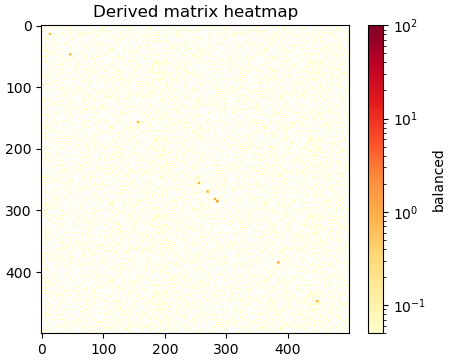

In [28]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(hic_mat, cmap="YlOrRd",norm = LogNorm(vmax=100, vmin = 0.05))
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Derived matrix heatmap")
plt.show()

In [48]:
card = oneChain.sum()

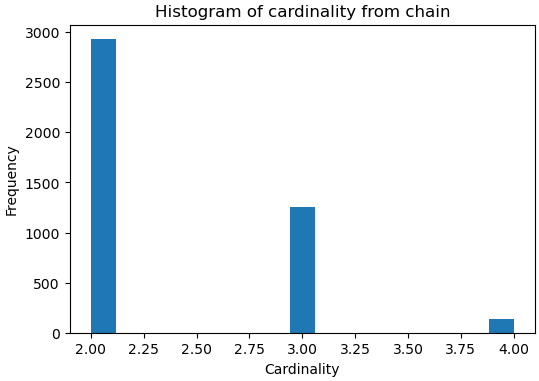

In [49]:
# Generate a histogram
plt.figure(figsize=(6,4))
plt.hist(card, bins='auto')

# Add labels and title
plt.xlabel('Cardinality')
plt.ylabel('Frequency')
plt.title('Histogram of cardinality from chain')

# Display the histogram
plt.show()

In [152]:
avgMat1 = averageNChains(seed=101,sampleSize=5,matching_files = matching_files)
chains1 = makeIncDF_fromChainDists(avgMat1)
print(chains1.shape)

avgMat2 = averageNChains(seed=102,sampleSize=5,matching_files = matching_files)
chains2 = makeIncDF_fromChainDists(avgMat2)
print(chains2.shape)

(500, 101)
(500, 85)


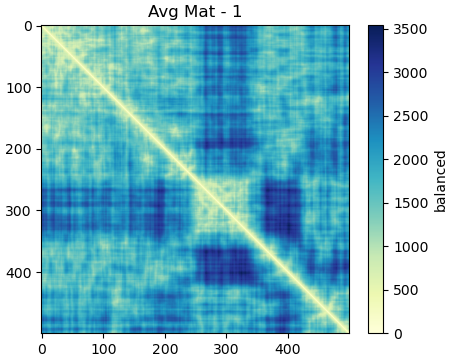

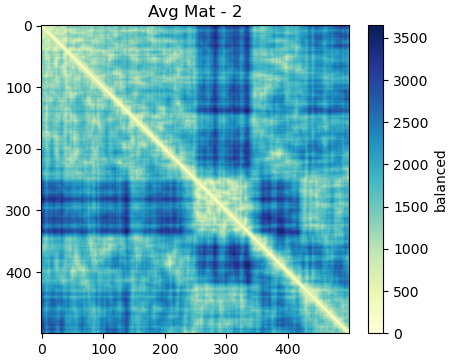

In [153]:
plt.figure(figsize=(6, 4))
im = plt.imshow(avgMat1, cmap="YlGnBu")
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Avg Mat - 1")
plt.show()

plt.figure(figsize=(6, 4))
im = plt.imshow(avgMat2, cmap="YlGnBu")
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Avg Mat - 2")
plt.show()

In [197]:
chains1_bin5 = increaseIncDF_binSize(chains1,5)
chains2_bin5 = increaseIncDF_binSize(chains2,5)

In [202]:
H1 = hnx.Hypergraph.from_incidence_dataframe(chains1)
H2 = hnx.Hypergraph.from_incidence_dataframe(chains2)

In [203]:
h1_nodes = []
for e in H1.edges:
    h1_nodes.append(tuple(H1.edges[e]))

h2_nodes = []
for e in H2.edges:
    h2_nodes.append(tuple(H2.edges[e]))

In [204]:
common_elements = set(h1_nodes).intersection(set(h2_nodes))
print(len(common_elements),len(h1_nodes),len(h2_nodes))

4 101 85


In [205]:
common_elements

{(53, 54), (53, 55), (54, 55), (281, 282)}

## SCRATCHPAD 

In [155]:
chains1 = makeIncDF_fromChainDists(exMat1,500)
chains2 = makeIncDF_fromChainDists(exMat2,500)

In [157]:
chains1by5 = increaseIncDF_binSize(chains1,5)
chains1by5 = chains1by5.loc[:,chains1by5.sum() >= 2]

In [158]:
chains2by5 = increaseIncDF_binSize(chains2,5)
chains2by5 = chains2by5.loc[:,chains2by5.sum() >= 2]

In [33]:
def increaseIncDF_binSize(df,binSize):
    result = []
    names = []
    for i in range(0,len(df) - binSize,binSize):
        summed_value = df.loc[i:i+binSize-1,:].sum()
        summed_value[summed_value > 0] = 1
        names.append(f"Bin{i}:{i+binSize-1}")
        result.append(summed_value)
    result_df = pd.DataFrame(result,index = names)
    return(result_df)

In [176]:
def dfToDict(df,result_dict):
    for col in df.columns:
        indices = df.index[df[col] == 1].tolist()
        key = '_'.join(indices)

        result_dict[key] = result_dict.get(key, 0) + 1
    return(result_dict)

In [134]:
def dictToDF(hpDict):
    indices = list(set(flatten([key.split('_') for key in hpDict.keys()])))
    columns = []
    colnames = []
    counter = 0

    for key, value in hpDict.items():
        counter+=1
        col_ix = key.split('_')
        column = pd.Series([0] * len(indices),index = indices)  # Initialize row with zeros
        column[col_ix] = 1
        colName = f"Read{counter}:{value}"
        colnames.append(colName)
        columns.append(column)

    df = pd.concat(columns,axis=1)
    df.columns = colnames
    return(df)

In [177]:
emptyDict = {}
chains1_dict = dfToDict(chains1by5,emptyDict)
emptyDict = {}
chains2_dict = dfToDict(chains2by5,emptyDict)


In [135]:
chains1_new = dictToDF(chains1_dict)
chains1_new.shape

(99, 605)

In [183]:
def constructFullDict(listOfDFs):
    result_dict = {}
    for df in listOfDFs:
        result_dict = dfToDict(df,result_dict)
    return(result_dict)

In [186]:
fullDF = dictToDF(result_dict)

In [187]:
fullDF.shape

(99, 1115)

In [188]:
fullDF

,Read1:10,Read2:2,Read3:1,Read4:9,Read5:2,Read6:4,Read7:2,Read8:2,Read9:5,Read10:3,...,Read1106:1,Read1107:9,Read1108:4,Read1109:3,Read1110:1,Read1111:1,Read1112:1,Read1113:2,Read1114:1,Read1115:2
Bin195:199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin100:104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin150:154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin375:379,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin20:24,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bin210:214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin115:119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin220:224,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin200:204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
